In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
# MNIST dataset
mnist_train = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [3]:
len(mnist_test), len(mnist_train)

(10000, 60000)

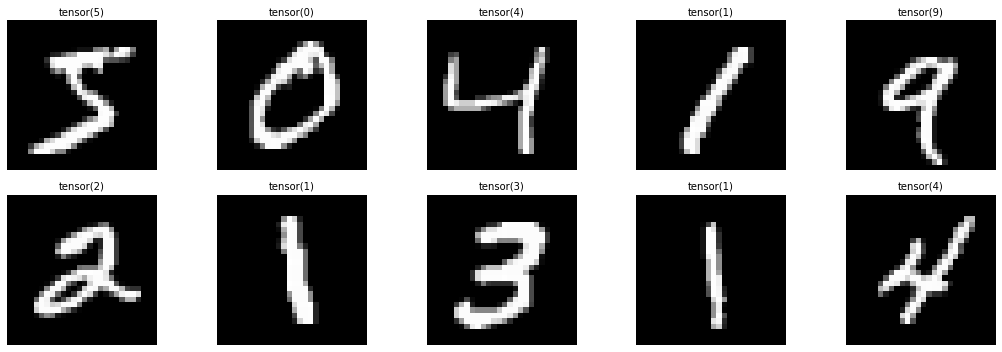

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

N = 10
for i in range(N):
    plt.subplot(2, int(N/2), i+1)
    plt.imshow(mnist_train.data[i], cmap='gray')
    plt.title(str(mnist_train.targets[i]), fontsize=10) # int8 => str 변환
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [5]:
batch_size = 100

train_loader = DataLoader(dataset=mnist_train,
                    batch_size=batch_size, # 배치 크기는 100
                    shuffle=True,
                    drop_last=True)

test_loader = DataLoader(dataset=mnist_test,
                    batch_size=batch_size, # 배치 크기는 100
                    shuffle=True,
                    drop_last=True)

len(train_loader)

600

In [6]:
class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()

    self.linear1 = nn.Sequential(nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 128))
    self.linear2 = nn.Linear(128, 10)

  def forward(self, x):
    out1 = self.linear1(x)
    out2 = self.linear2(out1)

    return F.softmax(out2)

In [16]:
# for reproducibility
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


# linear = nn.Linear(784, 10, bias=True).to(device)
linear = linear_model().to(device)

criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.Adam(linear.parameters(), lr=1e-4)

epochs = 10

for epoch in range(epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(train_loader)
    
    
    for X_train, y_train in train_loader:
    # 입력 이미지를 [batch_size × 784]의 크기로 reshape
    # 레이블은 원-핫 인코딩
      X_train = X_train.view(-1, 28*28).to(device)
      y_train = y_train.to(device)
  
      hypothesis = linear(X_train)

      optimizer.zero_grad()
      cost = criterion(hypothesis, y_train)
      cost.backward()
      optimizer.step()

      avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

다음 기기로 학습합니다: cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 0001 cost = 1.813589692
Epoch: 0002 cost = 1.582812905
Epoch: 0003 cost = 1.557315111
Epoch: 0004 cost = 1.546238661
Epoch: 0005 cost = 1.538415074
Epoch: 0006 cost = 1.532408834
Epoch: 0007 cost = 1.527233958
Epoch: 0008 cost = 1.522627115
Epoch: 0009 cost = 1.518882632
Epoch: 0010 cost = 1.515467644
Learning finished


Accuracy: 0.9460999965667725
Label:  5
Prediction:  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


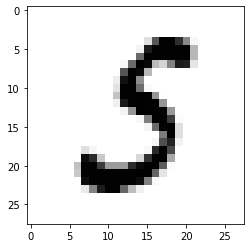

In [18]:
with torch.no_grad():
  linear.eval()
  X_test = mnist_test.data.view(-1, 28*28).float().to(device)
  y_test = mnist_test.targets.to(device)

  prediction = linear(X_test)
  correct_prediction = torch.argmax(prediction, 1) == y_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())
  
  # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
  r = random.randint(0, len(mnist_test) - 1)
  X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
  Y_single_data = mnist_test.test_labels[r:r + 1].to(device)
  print('Label: ', Y_single_data.item())
  
  single_prediction = linear(X_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())
  
  plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()